In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2
import ffmpeg
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
local = os.getcwd()
path_aei = local + '/aei/aei*'
path_Carti = local + '/Output_file/OutTerrestrial*'
path_Count = local + '/aeCount/aeCount*'
filenames_aei = sorted(glob.glob(path_aei))
filenames_Carti = sorted(glob.glob(path_Carti))
filenames_Count = sorted(glob.glob(path_Count))
len(filenames_aei), len(filenames_Carti), len(filenames_Count)

(158, 1575, 1574)

In [16]:
batch_no = 1
figures_aei_output = filenames_aei[::batch_no]
figures_Carti_output = filenames_Carti[::10 * batch_no]
figures_Count_output = filenames_Count[::10 * batch_no]

len(figures_aei_output), len(figures_Carti_output), len(figures_Count_output)

(158, 158, 158)

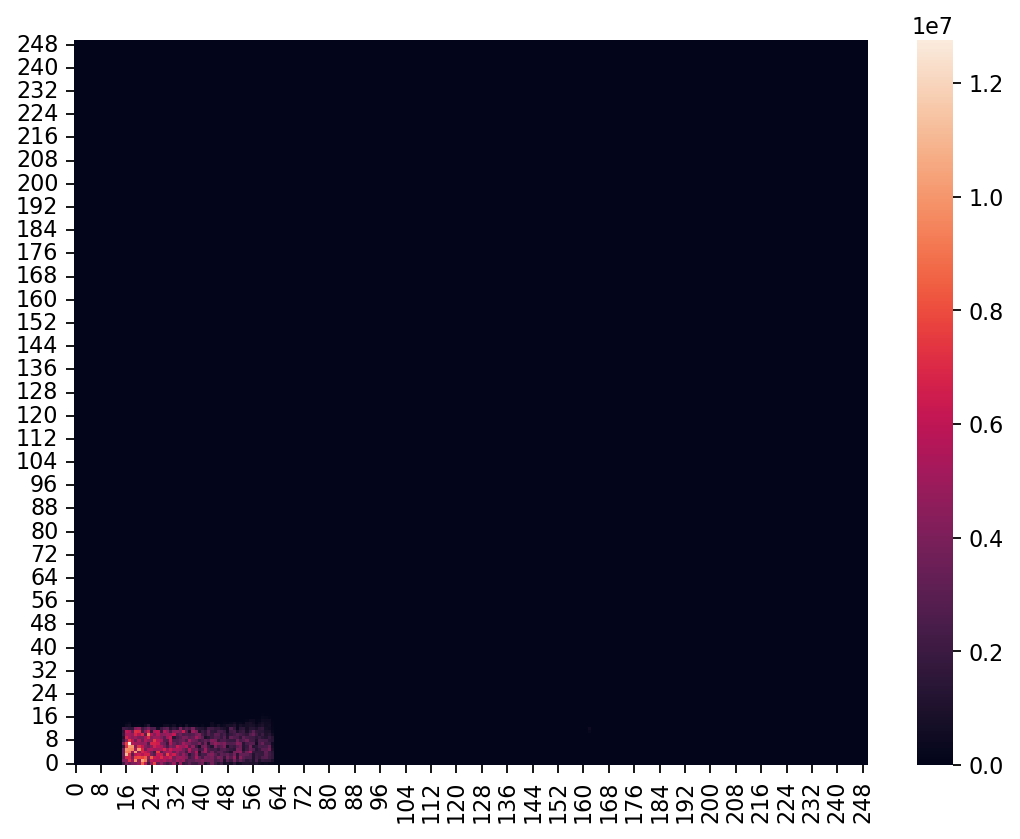

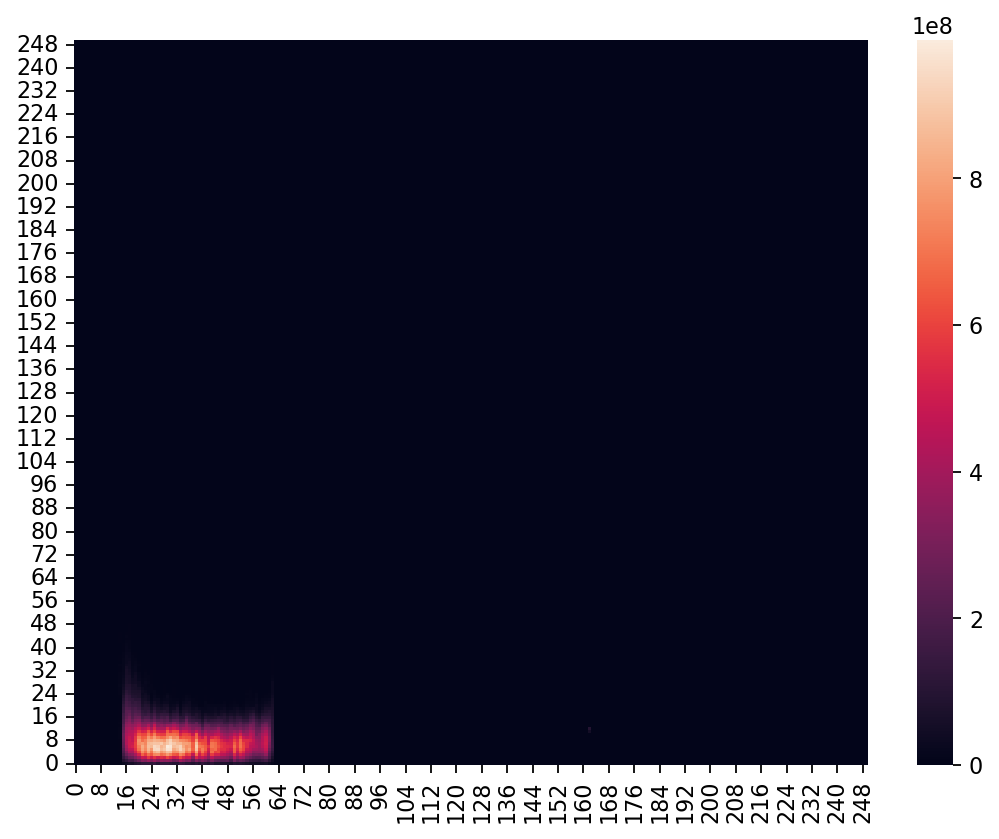

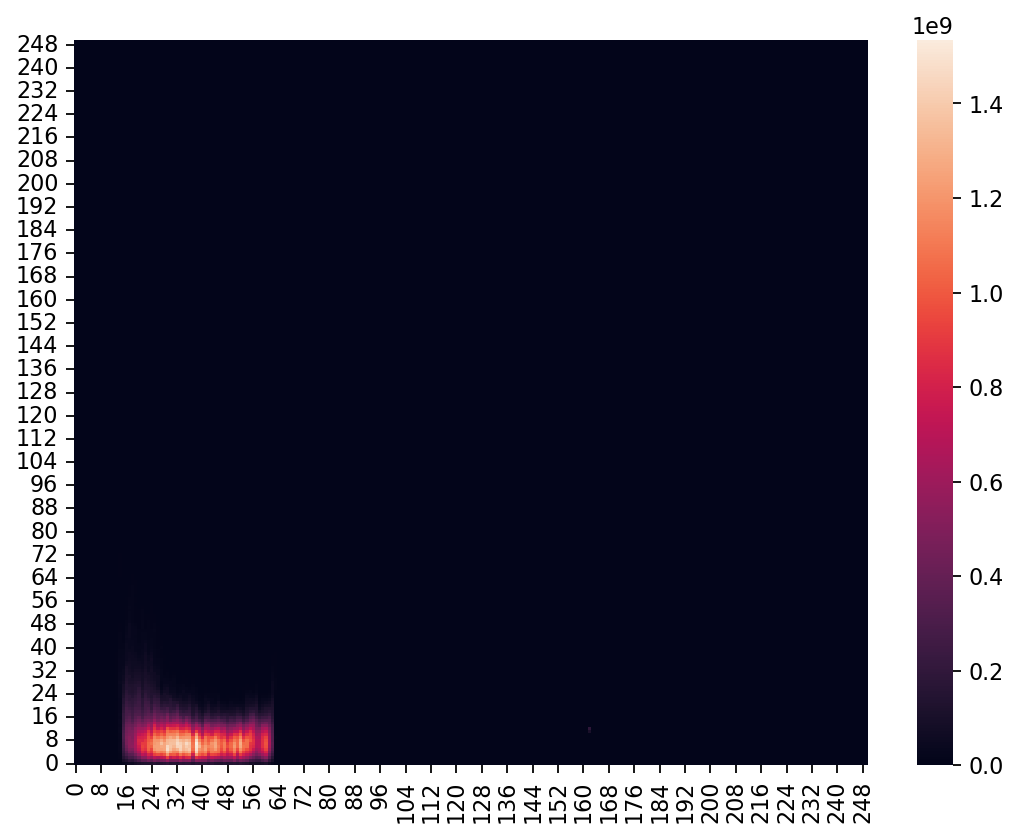

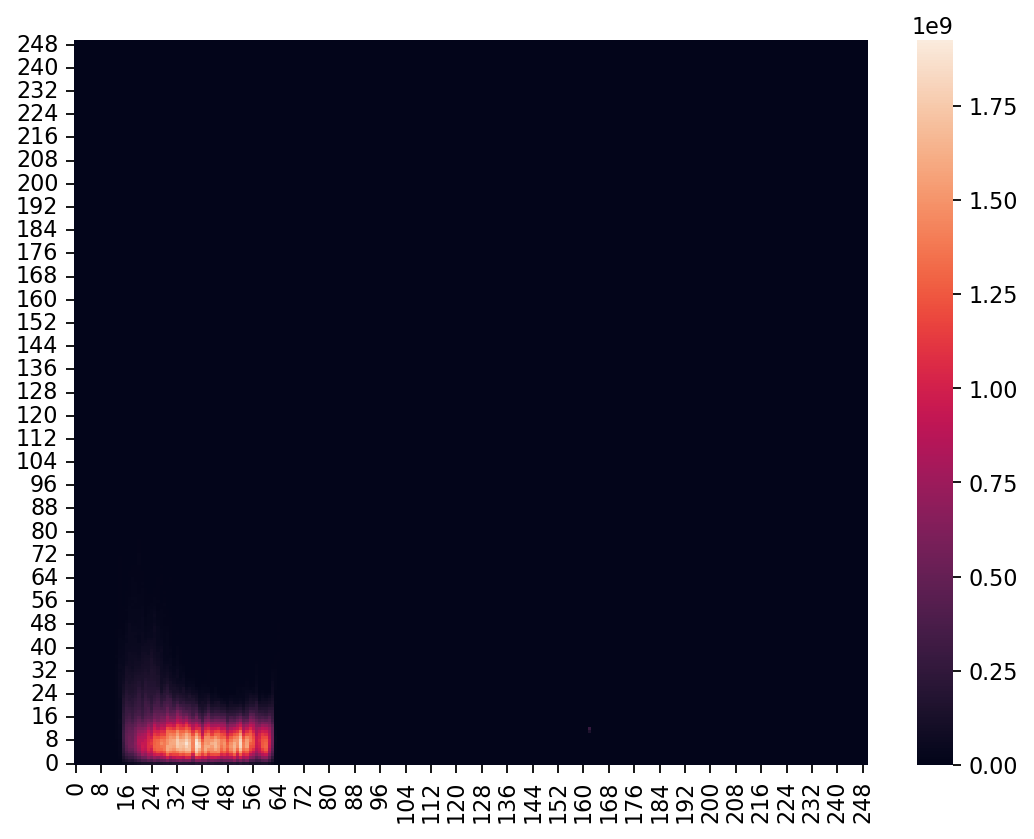

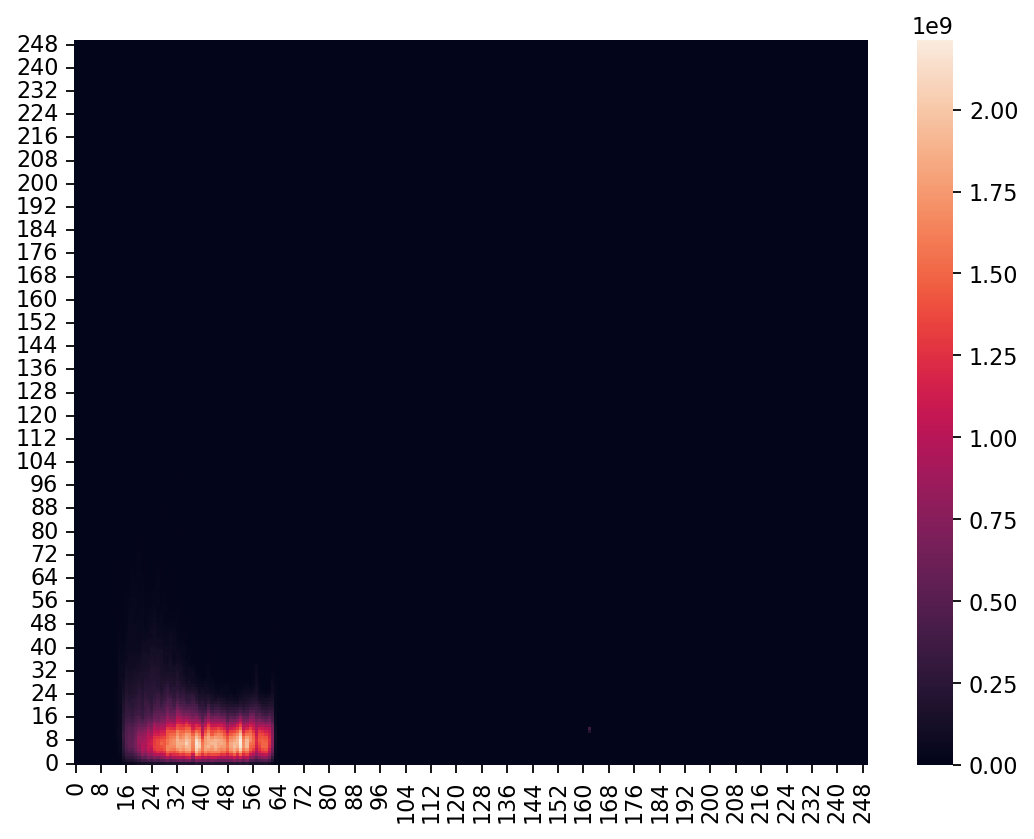

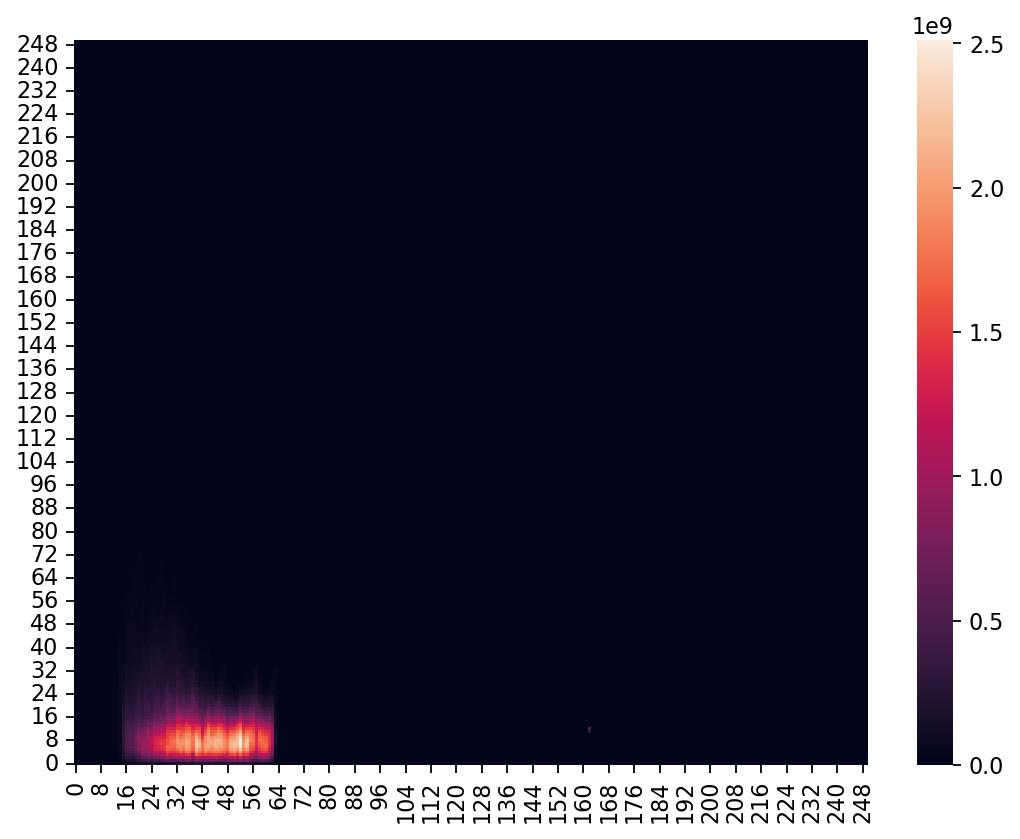

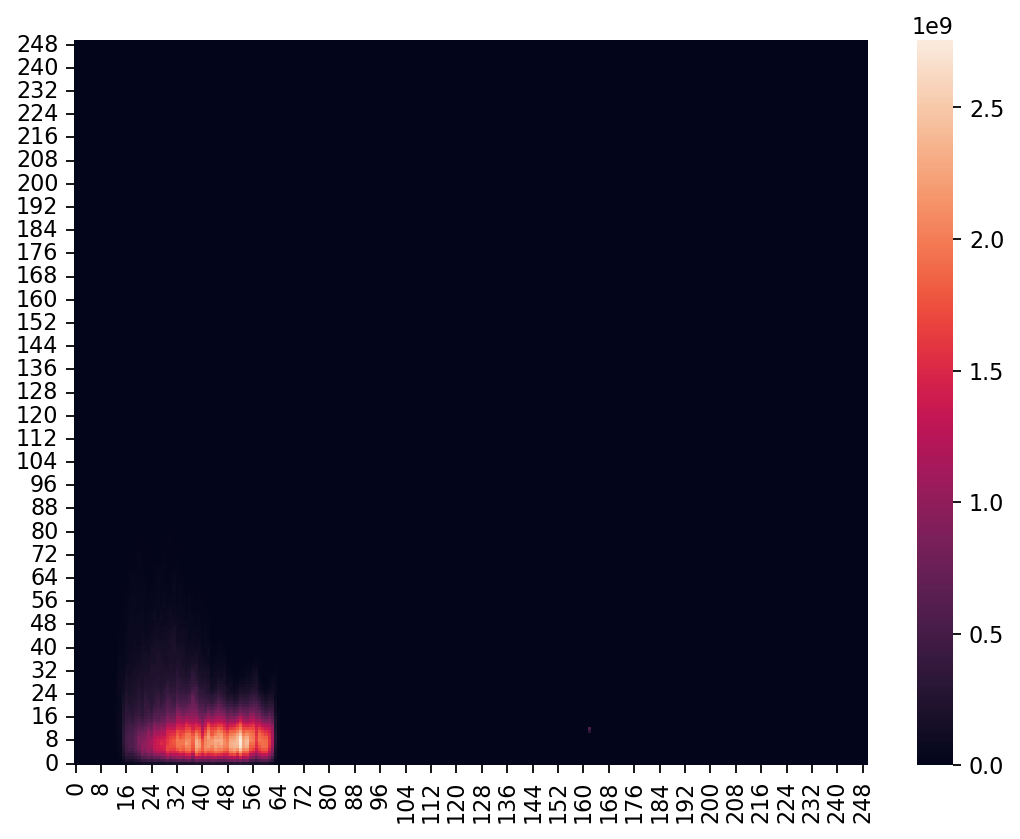

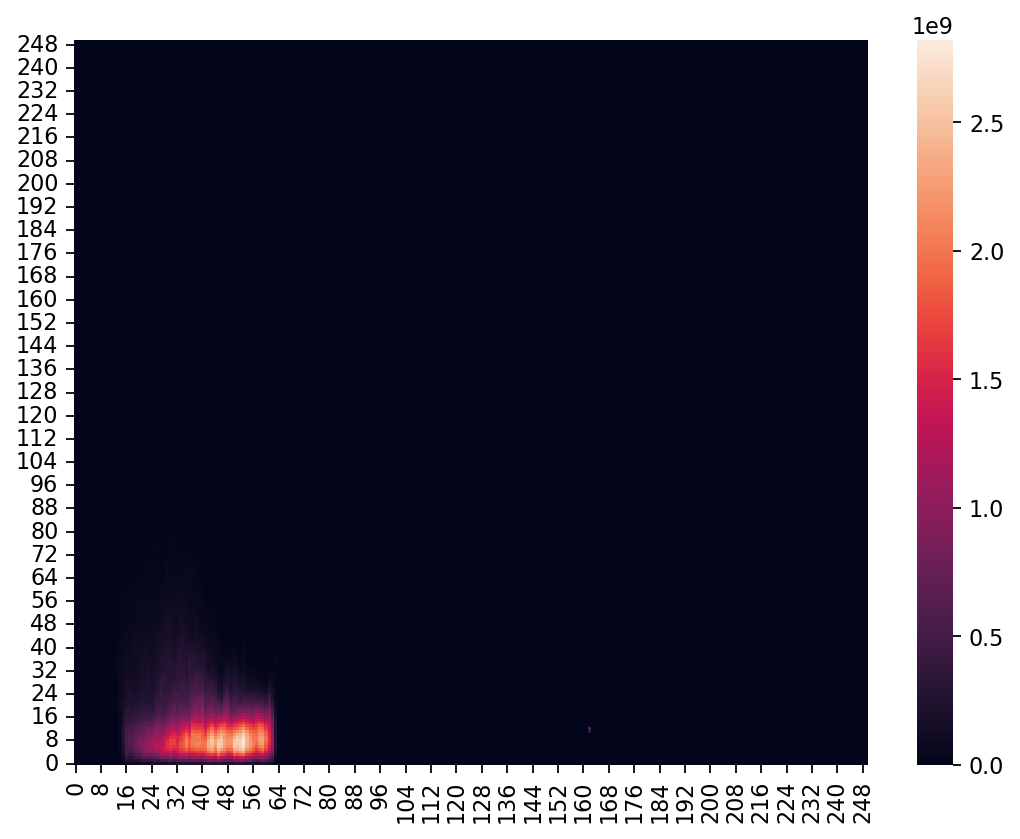

In [6]:
for step, figures_Count in enumerate(figures_Count_output):
    data = np.loadtxt(figures_Count)
    ae1 = data[0:250]
    plt.figure(figsize=(8, 6), dpi=80)
    ax = sns.heatmap(ae1)
    # ax.set_xlim(0,120)
    # ax.set_ylim(0,56)
    ax.invert_yaxis()
    plt.show()

In [7]:
df = pd.read_table(figures_aei_output[0], sep = ('\s+'), names = ['time', 'i', 'a', 'e', 'inc', 'Omega', 'w', 'Theta', 'E', 'M', 'm', 'r'])
sort = df.sort_values(by = ['a']).reset_index(drop=True)

In [19]:
for step, (figure_aei, figure_Carti) in enumerate(zip(figures_aei_output, figures_Carti_output)):
    #extract dataset from file
    plot_aei = pd.read_table(figure_aei, sep = ('\s+'), names = ['time', 'i', 'a', 'e', 'inc', 'Omega', 'w', 'Theta', 'E', 'M', 'm', 'r'])
    plot_aei['i'] = plot_aei['i'].replace(dict(zip(sort.i, sort.index)))
    plot_Carti = pd.read_table(figure_Carti, sep = ('\s+'), names = ['time', 'i', 'm', 'r', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Sx', 'Sy', 'Sz', 'amin', 'amax', 'emin', 'emax', 'aecount', 'aecountT', 'enccountT', 'test'])
    plot_Carti['i'] = plot_Carti['i'].replace(dict(zip(sort.i, sort.index)))
    
    #locate the heavyiest objects for perhilion and aphelion line plot
    max_mass = plot_aei.loc[plot_aei.m == max(plot_aei.m)]
    max_mass_e = float(max_mass.e)
    max_mass_a = float(max_mass.a)
    
    a_Mass = np.linspace(0.3, 6., 100)
    aphelion = max_mass_a * (1 + max_mass_e)
    perihelion = max_mass_a * (1 - max_mass_e)
    eMassQ = 1. - (aphelion / a_Mass)
    eMassq = (perihelion / a_Mass) - 1.
    line = pd.DataFrame(data = {'a': a_Mass, 'e': eMassQ, 'e_': eMassq})
    
    #title and time series
    title = str(step).zfill(10)
    time = str(int(plot_aei.time[0] / 1000000.))
    
    #plotting config
    fig = plt.figure(figsize = (20, 10), dpi = 80)
    fig.suptitle(title + ' / ' + time + ' Myr', fontsize = 16)
    
    #plots
    #Left plot
    ax = fig.add_subplot(121)
    ax.set_xlim(0, 5.5)
    ax.set_ylim(0, 1.)
    ax.set_zorder(1)
    ax.set_frame_on(False)
    ax.grid(True)
    if step != 0:
        ax = sns.lineplot(data = line, x = 'a', y = 'e', color = 'red', alpha = 0.6, zorder=10)
        ax = sns.lineplot(data = line, x = 'a', y = 'e_', color = 'red', alpha = 0.65, zorder=10)
    ax = sns.scatterplot(data = plot_aei, x = 'a', y = 'e', hue = 'i', size = 'm', palette = 'viridis', legend = False, zorder=15)

    
    ax2 = ax.twinx()
    ax2.axvspan(0, 6, facecolor="#e6e6e6")
    ax2 = sns.histplot(data = plot_aei, x = 'a', alpha = 0.1, weights = 'm', element = 'step', bins = 20)
    ax2.set_yticks(np.arange(0, 2.2e-6, 4.0e-7))
    ax2.set_ylim(0, 2.0e-6)
    ax2.set_zorder(0)
        
    #Right plot
    ax4 = fig.add_subplot(122)
    ax4.set_xlim(-5.5, 5.5)
    ax4.set_ylim(-5.5, 5.5)
    ax4.scatter(plot_Carti.x, plot_Carti.y, s = 10e5 * plot_Carti.r, c = plot_Carti.i, cmap = 'viridis')
    ax4.scatter(0, 0, s = 100, c = 'tab:red')
    ax4.grid(False)
    ax4.set_facecolor('gray')
    fig_name = f'/figs/{title}.png'
    
    # plt.show()
    plt.savefig(local+fig_name, dpi=300)
    plt.close()

In [20]:
image_folder = 'figs'
video_name = 'ae_giants.mp4'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 20, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
        